# Análisis de Simulaciones de Portafolios
Este notebook analiza un archivo CSV con resultados de simulaciones financieras en 6 apartados:
1. Mejores configuraciones de portafolio
2. Correlaciones entre variables
3. Estadísticas generales
4. Riesgo vs Retorno
5. Prueba de normalidad
6. Estrategias más exitosas

In [1]:
# Librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, shapiro

In [2]:
# Cargar el CSV (modifica la ruta si es necesario)
file_path = "tests.csv"  # Cambia esto si es necesario
df = pd.read_csv(file_path)
df.head()

,fecha_simulacion,fecha_inicio,fecha_fin,dinero_inicial,dinero_final,rentabilidad_total,tae,apalancamiento,margen,comision_total,numberStocksInPortfolio,prediccion,percentil,rlog_size
0,2025-07-11 23:49,2020-01-21,2025-07-10,10000.0,10179.55,0.0180,0.0033,0.5,0.001,0.64,1,1,95,24
1,2025-07-11 23:49,2020-01-21,2025-07-10,10000.0,24751.88,1.4752,0.1801,0.5,0.001,145.39,10,1,95,24
2,2025-07-11 23:49,2020-01-21,2025-07-10,10000.0,10184.55,0.0185,0.0033,0.5,0.002,0.64,1,1,95,24
3,2025-07-11 23:49,2020-01-21,2025-07-10,10000.0,13980.87,0.3981,0.0631,0.5,0.001,78.94,5,1,95,24
4,2025-07-11 23:56,2020-01-21,2025-07-10,10000.0,25374.95,1.5375,0.1854,0.5,0.002,148.56,10,1,95,24


## 1. Mejores configuraciones de portafolio

In [3]:
grouped = (
    df.groupby(["percentil", "prediccion", "numberStocksInPortfolio", "rlog_size"])
    .agg(media_tae=("tae", "mean"), conteo=("tae", "count"))
    .sort_values(by="media_tae", ascending=False)
)
grouped.head(10)

media_tae  conteo
percentil prediccion numberStocksInPortfolio rlog_size                   
50        3          1                       12          0.456500       1
          1          3                       12          0.396900       1
75        2          3                       24          0.351000       1
90        1          5                       36          0.340200       1
95        3          10                      36          0.328893      15
75        2          5                       24          0.319900       1
          1          3                       24          0.317600       1
50        3          3                       12          0.311000       1
95        3          10                      12          0.310260      15
50        3          5                       12          0.301500       1

## 2. Relación entre variables

In [4]:
cols = ["tae", "rentabilidad_total", "comision_total", "apalancamiento", "margen", "numberStocksInPortfolio"]
corr = df[cols].corr()
corr

,tae,rentabilidad_total,comision_total,apalancamiento,margen,numberStocksInPortfolio
tae,1.000000,0.965963,0.342202,0.326263,0.062005,0.721353
rentabilidad_total,0.965963,1.000000,0.365683,0.405968,0.033690,0.597055
comision_total,0.342202,0.365683,1.000000,0.170620,-0.165478,0.003344
apalancamiento,0.326263,0.405968,0.170620,1.000000,0.028140,-0.059256
margen,0.062005,0.033690,-0.165478,0.028140,1.000000,0.187709
numberStocksInPortfolio,0.721353,0.597055,0.003344,-0.059256,0.187709,1.000000


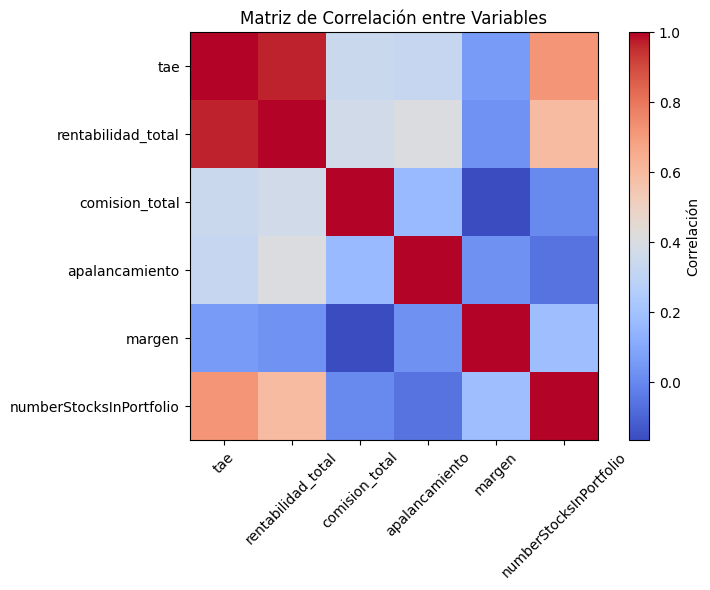

In [5]:
plt.figure(figsize=(8,6))
plt.imshow(corr, cmap='coolwarm', interpolation='none')
plt.colorbar(label='Correlación')
plt.xticks(range(len(cols)), cols, rotation=45)
plt.yticks(range(len(cols)), cols)
plt.title("Matriz de Correlación entre Variables")
plt.tight_layout()
plt.show()

## 3. Estadísticas generales

In [6]:
df[cols].describe()

,tae,rentabilidad_total,comision_total,apalancamiento,margen,numberStocksInPortfolio
count,1131.000000,1131.00000,1131.000000,1131.000000,1131.000000,1131.000000
mean,0.194418,1.86869,173.011609,0.979800,0.004900,8.240495
std,0.103683,1.23312,193.977211,0.503354,0.003087,3.193548
min,-0.212400,-0.72680,0.640000,0.300000,0.001000,1.000000
25%,0.135700,1.00655,68.745000,0.600000,0.002000,10.000000
50%,0.209300,1.82190,131.620000,1.000000,0.005000,10.000000
75%,0.266050,2.62625,245.395000,1.455000,0.007500,10.000000
max,0.472700,7.20830,3576.430000,1.800000,0.010000,10.000000


## 4. Análisis riesgo-retorno

In [7]:
rr = df.groupby(["apalancamiento", "percentil", "prediccion"]).agg(media_tae=("tae", "mean"), std_tae=("tae", "std")).reset_index()
rr["sharpe"] = rr["media_tae"] / rr["std_tae"]
rr.sort_values(by="sharpe", ascending=False).head(10)

,apalancamiento,percentil,prediccion,media_tae,std_tae,sharpe
53,1.2,95,1,0.267967,0.002223,120.523248
60,1.5,75,1,0.300550,0.003606,83.341546
61,1.5,80,1,0.355850,0.007000,50.833121
54,1.2,95,5,0.401000,0.009699,41.342403
59,1.5,60,1,0.186950,0.005162,36.217428
23,0.6,95,7,0.237710,0.007587,31.329837
6,0.3,75,1,0.164288,0.006544,25.103803
57,1.5,50,1,0.194300,0.008627,22.523090
75,1.7,75,5,0.318170,0.018512,17.187638
42,1.0,75,5,0.256250,0.014987,17.097926


## 5. Prueba de normalidad (Shapiro-Wilk)

In [8]:
tae_all = df["tae"].dropna()
stat, p = shapiro(tae_all)
print(f"Estadístico: {stat:.4f}, p-valor: {p:.4f}")
if p < 0.05:
    print("→ No es distribución normal")
else:
    print("→ Distribución normal aceptable")

Estadístico: 0.9717, p-valor: 0.0000
→ No es distribución normal


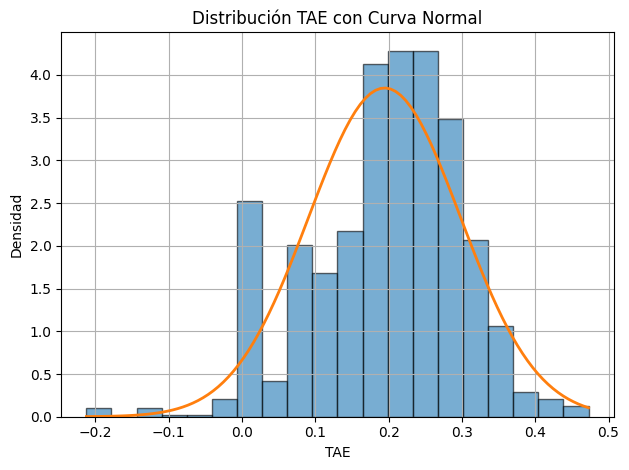

In [9]:
plt.figure()
count, bins, _ = plt.hist(tae_all, bins=20, density=True, alpha=0.6, edgecolor='black')
x = np.linspace(min(tae_all), max(tae_all), 100)
p_norm = norm.pdf(x, tae_all.mean(), tae_all.std())
plt.plot(x, p_norm, linewidth=2)
plt.title("Distribución TAE con Curva Normal")
plt.xlabel("TAE")
plt.ylabel("Densidad")
plt.grid()
plt.tight_layout()
plt.show()

## 6. Estrategias más exitosas

In [10]:
df.sort_values(by="tae", ascending=False)[[
    "tae", "rentabilidad_total", "comision_total", "apalancamiento",
    "percentil", "prediccion", "numberStocksInPortfolio", "rlog_size"
]].head(10)

,tae,rentabilidad_total,comision_total,apalancamiento,percentil,prediccion,numberStocksInPortfolio,rlog_size
1041,0.4727,7.2083,133.52,1.70,95,5,10,22
296,0.4565,6.9961,3576.43,1.00,50,3,1,12
1059,0.4544,6.6686,122.67,1.70,95,5,10,22
1077,0.4432,6.3543,118.60,1.70,95,5,10,22
1068,0.4400,6.2644,124.44,1.70,95,5,10,22
780,0.4370,6.1822,115.16,1.80,95,5,10,22
779,0.4333,6.0833,111.77,1.50,95,5,10,22
795,0.4311,6.0245,115.18,1.67,95,5,10,22
1050,0.4300,5.9959,120.46,1.70,95,5,10,22
1047,0.4214,5.7698,95.43,1.70,95,3,10,22
